In [26]:
import numpy as np
np.set_printoptions(threshold=np.inf)
from astropy.io import fits
from astropy.table import Table
import scipy
import matplotlib.pyplot as plt

# %pip install fortranformat
# %pip install rpy2
from survival_analysis import setup, ats_fit, kaplan_meier

hdul = fits.open("Data/HI-withMA-withPIPE3D.fits")
dataTable = Table(hdul[1].data)

Aligned_color = 'tab:blue'
MA_color = 'tab:orange'

Total galaxy count: 7277


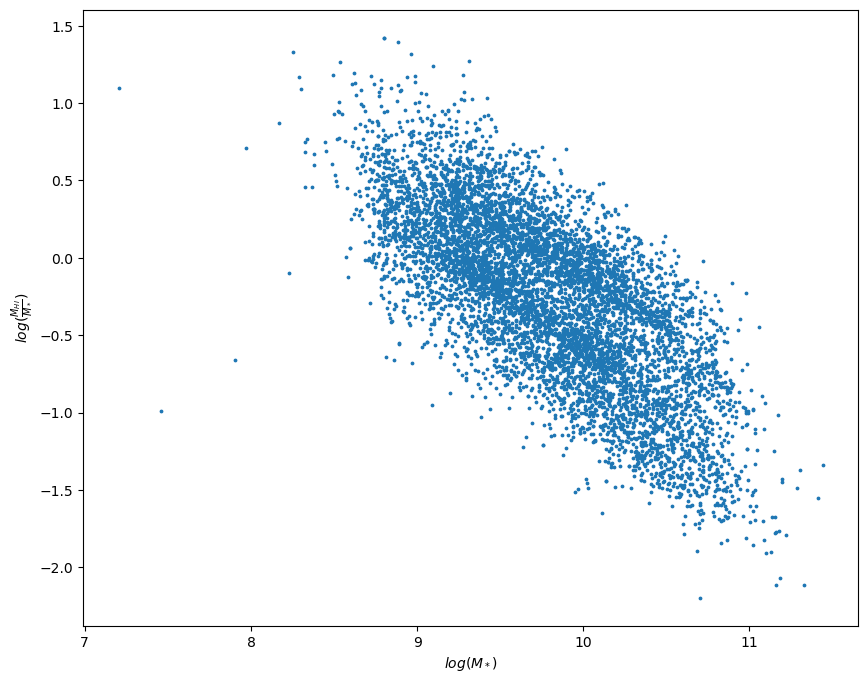

In [3]:
trimmedTable = dataTable[(dataTable['LOGMSTARS'] >= 5) & ((dataTable['LOGHILIM200KMS'] >= 0) | (dataTable['LOGMHI'] >= 0))]
# Setting minimum LOGMSTARS of 5 omits one outlier in the very far top left of the plot
trimmedTable['Best_HI'] = np.empty(len(trimmedTable))
for row in trimmedTable:
    row['Best_HI'] = max(row['LOGMHI'], row['LOGHILIM200KMS'])
print(f'Total galaxy count: {len(trimmedTable)}') # 7278

'''
We remove any galaxies without measured values of M_HI or M_Stel, which is very important to note.
We include galaxies with no M_HI if they have a reported upper limit for this value.
'''

plt.figure(figsize=(10,8))
plt.scatter(trimmedTable['LOGMSTARS'], trimmedTable['Best_HI'] - trimmedTable['LOGMSTARS'] , s = 3)
plt.xlabel('$log(M_*)$')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting
plt.show()

# Important to note that an outlying aligned galaxies has been cropped from the far top left of the plot
# by setting the minimum LOGMSTARS value to 5 instead of 0

In [4]:
trimmedTable

plateifu,ang_stellar,ang_ha,OBJRA_1,OBJDEC_1,LOGMSTARS,VOPT,RMS,LOGHILIM200KMS,SNR,FHI,LOGMHI,log_SFR_Ha,log_Mass,log_SFR_ssp,Best_HI
str12,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
8622-3703,199.0,18.5,351.2254638671875,14.216151237487793,9.574823379516602,7681.337,2.2,-999.0,7.0,1.1,9.45,-0.76266069438179,10.1095346278908,-0.0297115349713745,9.449999809265137
8952-3704,294.5,254.0,206.08572387695312,26.084192276000977,10.065818786621094,8474.986,2.1179023,9.313545,-999.0,-999.0,-999.0,-1.88390897415109,10.6245767970672,-1.12904874352718,9.313545227050781
8093-6103,307.5,56.5,19.590383529663086,15.409425735473633,10.558267593383789,11290.798,2.6958663,9.665635,-999.0,-999.0,-999.0,-1.22231648781419,11.0523757749862,-1.09591408005801,9.665635108947754
11021-3702,109.0,11.5,198.170838903,53.7147359215,10.069888406629797,7179.6,1.6034691,8.895555,-999.0,-999.0,-999.0,-1.41459435719359,10.6782050812892,-1.23823666873358,8.895554542541504
10500-12703,213.5,318.5,137.160232544,32.5929527283,10.111501108387221,4265.7,1.6677163,8.462318,-999.0,-999.0,-999.0,-0.418348998668357,10.7006634820747,-1.02629012184449,8.462318420410156
9866-3701,30.0,207.0,243.0633087158203,31.818723678588867,10.143058776855469,14803.465,2.9166586,9.932747,-999.0,-999.0,-999.0,-0.475604102126105,10.6479522461653,-0.747342993616185,9.932746887207031
8446-1902,60.0,249.5,206.154337129,37.1716322286,10.182503100253506,7976.7,1.5506914,-999.0,7.386829,2.6994867,9.916596,-1.03910783643127,10.6203606121023,-1.56422083455269,9.916596412658691
8077-3704,24.5,203.0,42.1984450083,-0.10918489701,10.024859049659549,7396.6,1.590993,8.917882,-999.0,-999.0,-999.0,-0.532436446086757,10.3649669290159,-0.323395010622631,8.917881965637207
8077-3704,24.5,203.0,42.19844436645508,-0.10918489843606949,10.024859428405762,7396.7554,2.9233203,9.336035,-999.0,-999.0,-999.0,-0.532436446086757,10.3649669290159,-0.323395010622631,9.336034774780273


We seek to identify which galaxies have misalignent. These are simply those with values for position angles, from Zhou et al. 2022

In [5]:
MA_table = trimmedTable[trimmedTable['ang_stellar'].astype(str) != str(np.nan)]
Aligned_table = trimmedTable[trimmedTable['ang_stellar'].astype(str) == str(np.nan)]

Aligned_Lims = np.array(Aligned_table['LOGHILIM200KMS'] == -999)
MA_Lims = np.array(MA_table['LOGHILIM200KMS'] == -999)

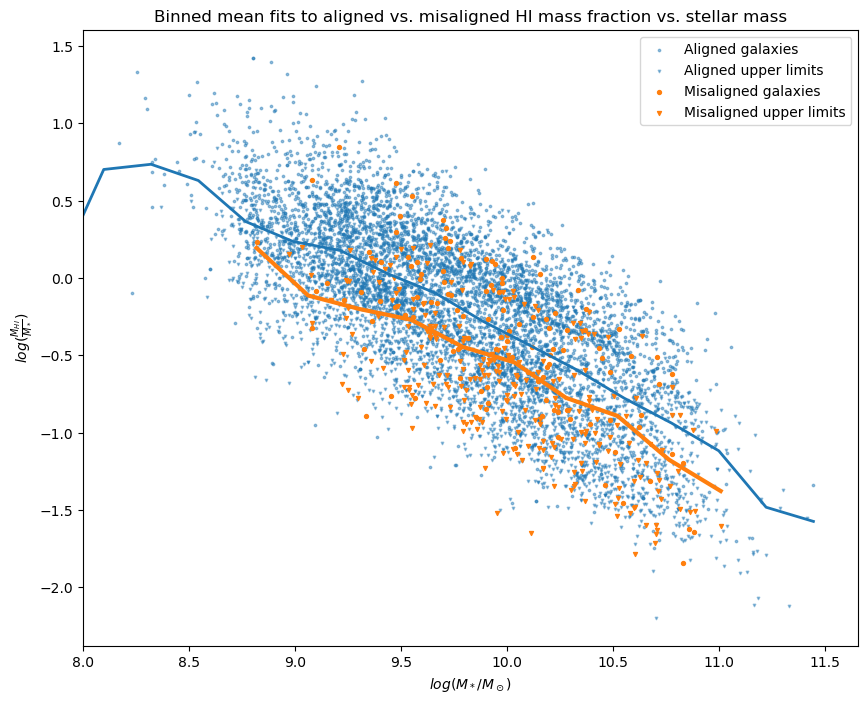

In [7]:
plt.figure(figsize=(10,8))

plt.scatter(Aligned_table['LOGMSTARS'][Aligned_Lims], (Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'])[Aligned_Lims], s = 3, alpha = .45, label = 'Aligned galaxies', color = Aligned_color)
plt.scatter(Aligned_table['LOGMSTARS'][~Aligned_Lims], (Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'])[~Aligned_Lims], s = 3, alpha = .45, label = 'Aligned upper limits', color = Aligned_color, marker = 'v')

plt.scatter(MA_table['LOGMSTARS'][MA_Lims], (MA_table['Best_HI'] - MA_table['LOGMSTARS'])[MA_Lims], s = 8, label = 'Misaligned galaxies', color = MA_color)
plt.scatter(MA_table['LOGMSTARS'][~MA_Lims], (MA_table['Best_HI'] - MA_table['LOGMSTARS'])[~MA_Lims], s = 8, label = 'Misaligned upper limits', color = MA_color, marker = 'v')

plt.xlabel(r'$log(M_*/M_\odot)$')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting
plt.legend()

alignedBin = scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], 'mean', bins=20)
alignedXs = np.linspace(min(Aligned_table['LOGMSTARS']), max(Aligned_table['LOGMSTARS']), 20)
plt.plot(alignedXs, alignedBin[0], lw=2, color = Aligned_color)

MABin = scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], 'mean', bins=10)
MAXs = np.linspace(min(MA_table['LOGMSTARS']), max(MA_table['LOGMSTARS']), 10)
plt.plot(MAXs, MABin[0], lw=3, color = MA_color)

plt.title('Binned mean fits to aligned vs. misaligned HI mass fraction vs. stellar mass')
plt.xlim(left = 8)
plt.show()

We can also plot binned medians, including standard deviation:

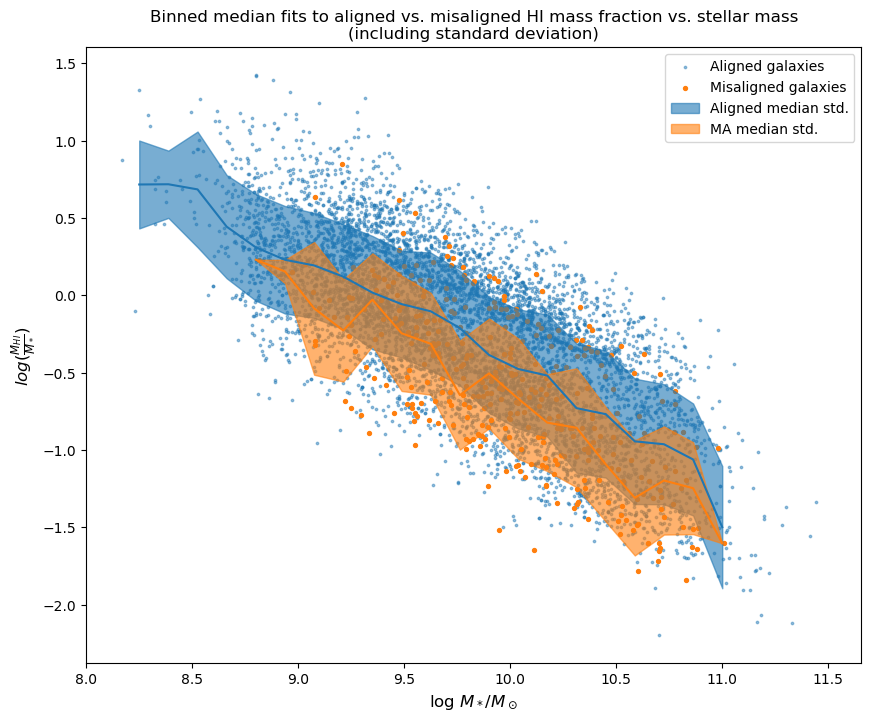

In [20]:
myBins = np.arange(8.25, 11.25, (11.25-8.5)/20)

plt.figure(figsize=(10,8))

plt.scatter(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], s = 3, alpha = .45, label = 'Aligned galaxies', color = Aligned_color)
plt.scatter(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], s = 8, label = 'Misaligned galaxies', color = MA_color)

plt.xlabel(r'log $M_*/M_\odot$', fontsize = 'large')
plt.ylabel(r'$log(\frac{M_{HI}}{M_*})$', fontsize = 'large') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting

Alignedmedians, Alignededgesmedian, Alignednummedian = scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'],'median',bins=myBins)
Alignedstds, Alignededgesstd, Alignednumstd=scipy.stats.binned_statistic(Aligned_table['LOGMSTARS'], Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'],'std',bins=myBins)
plt.plot(Alignededgesmedian[:-1], Alignedmedians, ls='-', alpha=1, color=Aligned_color)
plt.fill_between(Alignededgesmedian[:-1],Alignedmedians-Alignedstds,Alignedmedians+Alignedstds,alpha=.6, color=Aligned_color, label='Aligned median std.')

MAmedians, MAedgesmedian, MAnummedian = scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], statistic = 'median', bins=myBins)
MAstds,MAedgesstd,MAnumstd=scipy.stats.binned_statistic(MA_table['LOGMSTARS'], MA_table['Best_HI'] - MA_table['LOGMSTARS'], statistic = 'std', bins=myBins)
plt.plot(MAedgesmedian[:-1], MAmedians, ls='-', alpha=1, color=MA_color)
plt.fill_between(MAedgesmedian[:-1],MAmedians-MAstds,MAmedians+MAstds,alpha=.6, color=MA_color, label='MA median std.')

plt.title('Binned median fits to aligned vs. misaligned HI mass fraction vs. stellar mass\n(including standard deviation)')
plt.xlim(left = 8)
plt.legend()
plt.show()

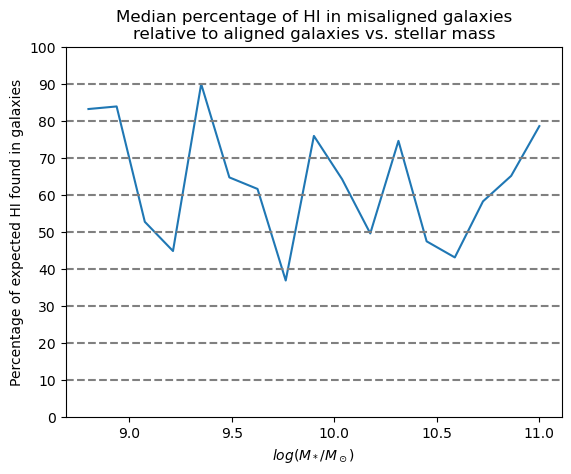

In [18]:
plt.plot(Alignededgesmedian[:-1], 10**(MAmedians - Alignedmedians) * 100, ls='-', alpha=1)
for val in np.arange(10, 100, 10):
    plt.axhline(val, color = 'gray', linestyle = '--')
plt.yticks(np.arange(0, 120, 10))
plt.title('Median percentage of HI in misaligned galaxies\nrelative to aligned galaxies vs. stellar mass')
plt.ylabel('Percentage of expected HI found in galaxies')
plt.xlabel(r'$log(M_*/M_\odot)$')
plt.ylim(0, 100)
plt.show()

Misaligned galaxies have, on average, ~40-80% the expected amount of HI compared to their aligned counterparts at similar stellar mass (taking median mass fractions)

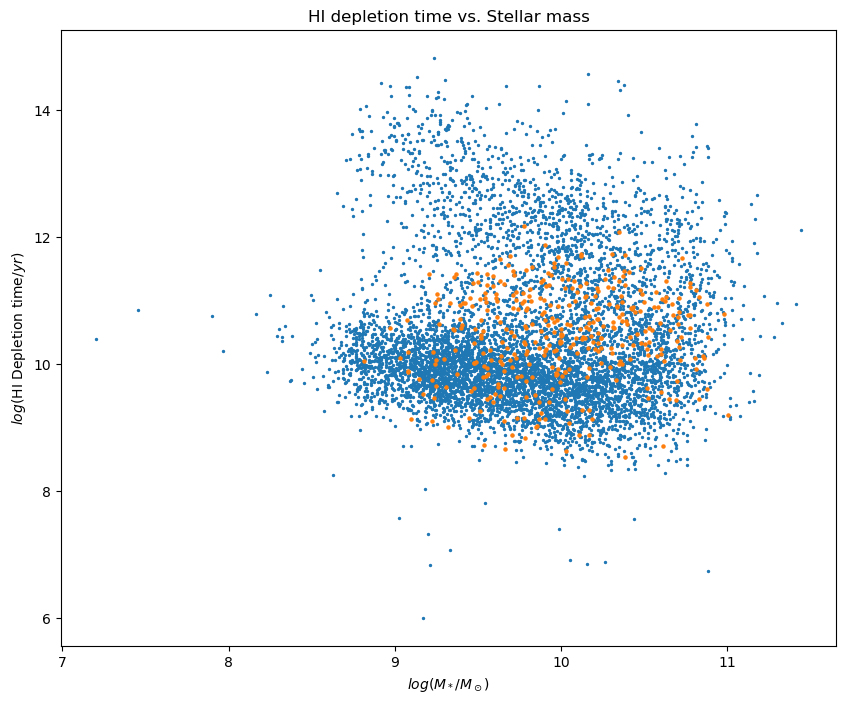

In [19]:
# Omitting galaxies without recorded SFR values by selecting for non-nan values:
'''
https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
x = x[~numpy.isnan(x)]
'''

Aligned_depletion = np.array(Aligned_table['Best_HI'] - Aligned_table['log_SFR_Ha'])
MA_depletion = np.array(MA_table['Best_HI'] - MA_table['log_SFR_Ha'])

plt.figure(figsize = (10, 8))
plt.scatter(Aligned_table['LOGMSTARS'][~np.isnan(Aligned_depletion)], Aligned_depletion[~np.isnan(Aligned_depletion)], s = 2)
plt.scatter(MA_table['LOGMSTARS'][~np.isnan(MA_depletion)], MA_depletion[~np.isnan(MA_depletion)], s = 5)
plt.title(r'HI depletion time vs. Stellar mass')
plt.xlabel(r'$log(M_*/M_\odot)$')
plt.ylabel(r'$log($HI Depletion time$/yr)$')
plt.show()

     lim     gs
1      1 10.440
2      1 10.192
3      1  9.675
4      1  9.705
5      1  9.382
6      0  9.837
7      0 11.573
8      0 12.464
9      0  9.514
10     1  9.784
11     1  9.348
12     0 11.266
13     1 10.113
14     1 10.157
15     0  9.991
16     1 10.271
17     1  9.758
18     1  9.539
19     0 10.605
20     1 10.039
21     1 10.554
22     1 10.306
23     1 10.729
24     1 10.512
25     1  9.846
26     1 10.336
27     1 10.386
28     1 10.438
29     0 13.390
30     1  9.657
31     1  9.824
32     1 10.352
33     1 10.028
34     1  9.811
35     1  8.815
36     0  9.421
37     1  9.255
38     1  9.933
39     0  9.897
40     0  9.865
41     1  9.974
42     0 11.672
43     0 11.781
44     0 12.780
45     0 12.756
46     0  9.194
47     0  9.091
48     1  9.713
49     0  9.003
50     1 10.246
51     1 10.541
52     0 13.119
53     0 13.702
54     0 12.846
55     0 12.152
56     0 13.077
57     0 12.499
58     0 12.017
59     1 10.378
60     1  9.396
61     1 10.041
62     1

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


    lim     gs
1     1 10.213
2     0 11.197
3     0 10.888
4     0 10.310
5     0  8.881
6     0 10.408
7     1 10.956
8     0  9.450
9     0  9.868
10    0 11.053
11    0 10.849
12    0 11.248
13    0 10.512
14    0 10.568
15    0 10.828
16    1 11.000
17    0  9.952
18    0 12.081
19    0 10.935
20    0  9.920
21    0 10.911
22    0 10.341
23    1 10.736
24    0  9.448
25    1 11.066
26    0 11.037
27    1  9.944
28    1 11.562
29    0  9.099
30    0  9.615
31    0  9.912
32    0 10.706
33    1 10.250
34    0 10.415
35    0 11.261
36    0 11.370
37    0 10.099
38    0 10.598
39    0 11.014
40    0 11.282
41    1 10.558
42    0 10.980
43    0 11.334
44    0 10.289
45    0 11.117
46    0  9.960
47    0 10.427
48    0 11.271
49    0  9.722
50    1 10.263
51    0 11.680
52    1  9.226
53    0 10.730
54    0 10.501
55    1 10.616
56    0  9.153
57    0 10.072
58    0 10.249
59    1  9.743
60    0 10.865
61    0 10.323
62    0  9.647
63    0  9.397
64    1 10.821
65    1 10.692
66    0 12

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


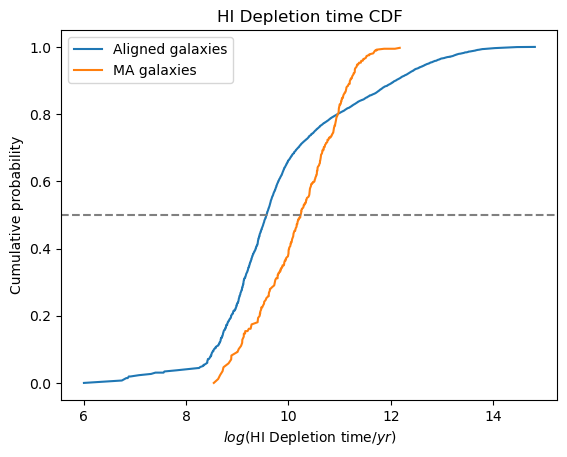

In [88]:
Aligned_Depletion_KM = kaplan_meier(Aligned_depletion[~np.isnan(Aligned_depletion)], Aligned_Lims[~np.isnan(Aligned_depletion)])
MA_Depletion_KM = kaplan_meier(MA_depletion[~np.isnan(MA_depletion)], MA_Lims[~np.isnan(MA_depletion)])

plt.plot(Aligned_Depletion_KM['km']['x'], Aligned_Depletion_KM['km']['surv'], label = 'Aligned galaxies', color = Aligned_color)
plt.plot(MA_Depletion_KM['km']['x'], MA_Depletion_KM['km']['surv'], label = 'MA galaxies', color = MA_color)
plt.xlabel(r'$log($HI Depletion time$/yr)$')
plt.ylabel('Cumulative probability')
plt.title('HI Depletion time CDF')
plt.legend()
plt.axhline(0.5, color = 'gray', linestyle = '--')
plt.show()

#TODO: Not confident in this result because it compares HI mass to an SFR derived from Ha (Unless that's fine? Need to consult KLM)

     lim     gs
1      1  0.921
2      1 -0.083
3      1 -0.199
4      1 -0.386
5      1 -0.120
6      0 -0.194
7      0 -1.190
8      0 -0.462
9      0 -0.153
10     1 -1.474
11     1 -0.708
12     0 -1.177
13     1  0.579
14     1  0.365
15     0 -0.261
16     1  0.275
17     1 -0.061
18     1 -0.126
19     0 -0.949
20     1  0.044
21     1  0.503
22     1  0.282
23     1 -0.738
24     1  0.141
25     1 -0.558
26     1  0.177
27     1  0.662
28     1  0.397
29     0 -1.420
30     1  0.046
31     1  0.329
32     1 -0.207
33     1  0.080
34     1  0.448
35     1 -1.181
36     0 -0.963
37     1  0.286
38     1  0.314
39     0 -0.204
40     0 -0.503
41     1 -0.443
42     0 -0.542
43     0 -0.534
44     0 -0.640
45     0 -0.675
46     0 -1.104
47     0 -0.474
48     1  0.088
49     0  0.104
50     1  0.049
51     1  0.769
52     1  0.483
53     0 -0.414
54     0 -0.136
55     0 -0.625
56     0 -0.897
57     0 -0.222
58     0 -0.405
59     0 -2.197
60     1  0.562
61     1 -0.310
62     1

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


    lim     gs
1     1 -0.125
2     0 -0.752
3     0 -0.893
4     0 -1.174
5     0 -1.649
6     0 -0.210
7     1 -0.266
8     0 -1.107
9     0 -0.689
10    0 -0.606
11    0 -0.204
12    0  0.195
13    0 -0.931
14    0  0.153
15    0 -1.117
16    1 -0.850
17    0 -1.517
18    0 -0.388
19    0 -0.983
20    0 -1.136
21    0 -0.858
22    0 -0.325
23    1 -0.669
24    0 -1.599
25    1 -0.497
26    0 -0.650
27    1  0.257
28    1 -0.533
29    0 -0.828
30    0 -0.312
31    0 -1.133
32    0 -0.029
33    1 -0.894
34    0 -0.719
35    0 -0.229
36    0 -0.392
37    0  0.199
38    0 -1.038
39    0 -0.778
40    0  0.186
41    1 -0.152
42    0 -0.759
43    0 -0.628
44    0 -1.444
45    0 -0.815
46    0 -0.706
47    0 -1.003
48    0 -0.706
49    0 -0.792
50    1 -0.296
51    0 -0.090
52    1 -0.728
53    0 -0.809
54    0 -0.607
55    1  0.103
56    0  0.086
57    0 -0.775
58    0 -0.628
59    1 -0.077
60    0 -1.066
61    0 -0.914
62    0 -0.195
63    0 -0.494
64    1 -0.083
65    1 -0.205
66    0  0

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


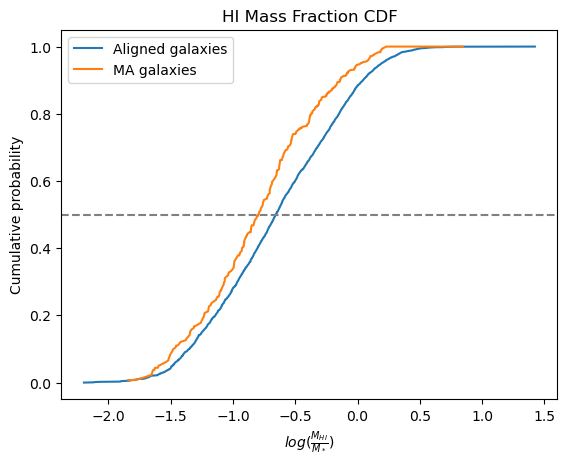

In [22]:
Aligned_Frac_KM = kaplan_meier(Aligned_table['Best_HI'] - Aligned_table['LOGMSTARS'], Aligned_Lims)
MA_Frac_KM = kaplan_meier(MA_table['Best_HI'] - MA_table['LOGMSTARS'], MA_Lims)

plt.plot(Aligned_Frac_KM['km']['x'], Aligned_Frac_KM['km']['surv'], label = 'Aligned galaxies', color = Aligned_color)
plt.plot(MA_Frac_KM['km']['x'], MA_Frac_KM['km']['surv'], label = 'MA galaxies', color = MA_color)
plt.ylabel(r'Cumulative probability')
plt.xlabel(r'$log(\frac{M_{HI}}{M_*})$') # 'raw' string denoted w/ r before quote to allow for LaTeX formatting
plt.title('HI Mass Fraction CDF')
plt.legend()
plt.axhline(0.5, color = 'gray', linestyle = '--')
plt.show()

In [89]:
# print(Aligned_Frac_KM['km']['surv'][1435]) # From guess and check, close to 0.50 at index 1435
# print(MA_Frac_KM['km']['surv'][208]) # From guess and check, close to 0.50 at index 208

print('Difference in logs of mass fractions at ~0.50:', MA_Frac_KM['km']['x'][208] - Aligned_Frac_KM['km']['x'][1435])
print('This indicates that misaligned galaxies\' mass fractions are only', 10**(MA_Frac_KM['km']['x'][208] - Aligned_Frac_KM['km']['x'][1435]), '% of the their aligned counterparts.')

Difference in logs of mass fractions at ~0.50: -0.14100000000000001
This indicates that misaligned galaxies' mass fractions are only 0.7227698036021702 % of the their aligned counterparts.
